## Import libraries needed

In [17]:
import pandas as pd
import numpy as np
import boto3
from pyathena import connect
import sagemaker

In [5]:
## set the session and roles for AWS
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Setup connection to Athena to pull in tables

In [6]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [7]:
# create the connection, this will be used anytime we need to query data from Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [8]:
## Verify we have the database created
statement = "SHOW DATABASES"
db_show = pd.read_sql(statement, conn)
db_show.head(5)
## store teh db_name in a variable
db_name = str(db_show.iloc[0]['database_name'])

In [9]:
## we need to query the tables in and do a Join so it is one table to run our EDA off
db_name

'default'

### figure out Athena connection

In [7]:
 # LEFT JOIN ads_508_team_5.order_payments_dataset op on o.order_id = op.order_id
 #                    LEFT JOIN ads_508_team_5.order_reviews_dataset ord on op.order_id = ord.order_id
 #                    LEFT JOIN ads_508_team_5.order_items_dataset oid on ord.order_id = oid.order_id
 #                    LEFT JOIN ads_508_team_5.products_dataset pd on oid.product_id = pd.product_id
 #                    LEFT JOIN ads_508_team_5.sellers_dataset sd on oid.seller_id = sd.seller_id
 #                    LEFT JOIN ads_508_team_5.geolocation_dataset gd_c on c.customer_zip_code_prefix = gd_c.geolocation_zip_code_prefix
 #                    LEFT JOIN ads_508_team_5.geolocation_dataset gd_s ON sd.seller_zip_code_prefix = gd_s.geolocation_zip_code_prefix

In [8]:
# join_statement = """SELECT * FROM
#                     ads_508_team_5.customers_dataset c
#                     INNER JOIN ads_508_team_5.orders_dataset o on c.customer_id = o.customer_id
#                     """

In [ ]:
# main_df = pd.read_sql(join_statement, conn)
# main_df.head()

## Read in customer and orders data

In [11]:
## customer_df 
customer_df = pd.read_csv('Data/customers_dataset.csv')
customer_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [12]:
order_items_df = pd.read_csv('Data/order_items_dataset.csv')
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [13]:
order_payments_df = pd.read_csv('Data/order_payments_dataset.csv')
order_payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [14]:
order_reviews_df = pd.read_csv('Data/order_reviews_dataset.csv')
order_reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [15]:
orders_df = pd.read_csv('Data/orders_dataset.csv')
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


* Given the columns that are listed in each of these datasets, not all of the columns in any of the orders dataset is needed, once to look at in more detail are order_items: price, freight_value. order_payments: payment_type, payment_installments, payment_value. Order_reviews: review_score, orders_dataset: order_status

In [37]:
## slice out columns needed
sliced_orders = orders_df[['order_id', 'customer_id', 'order_status', "order_purchase_timestamp"]]
sliced_items = order_items_df[['order_id', 'price', 'freight_value']]
sliced_payments = order_payments_df[['order_id', 'payment_type', 'payment_installments', 'payment_value']]
sliced_reviews = order_reviews_df[['order_id', 'review_score']]

In [38]:
# perform merge or inner join on customer_df
df_merged = customer_df.merge(
    sliced_orders, on = 'customer_id').merge(
    sliced_items, on = 'order_id').merge(
    sliced_payments, on = 'order_id').merge(
    sliced_reviews, on = 'order_id')
df_merged.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,price,freight_value,payment_type,payment_installments,payment_value,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,124.99,21.88,credit_card,2,146.87,4
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,289.00,46.48,credit_card,8,335.48,5
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,139.94,17.79,credit_card,7,157.73,5
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,149.94,23.36,credit_card,1,173.30,5
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,230.00,22.25,credit_card,8,252.25,5


In [50]:
## In order for us to get teh customer churn we need to figure out who has made reorders and who has not, we can use the customer_id key 
## and teh customer unique key

# conver teh timestamp to a date time
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
# get tehf irst and last purchase for each customer
purchase_dates = df_merged.groupby('customer_unique_id').agg(first_purchase=pd.NamedAgg(column='order_purchase_timestamp', aggfunc='min'),
                                                       last_purchase=pd.NamedAgg(column='order_purchase_timestamp', aggfunc='max')).reset_index()
#Calculate the repurchase time in days for each customer
purchase_dates['repurchase_time'] = (purchase_dates['last_purchase'] - purchase_dates['first_purchase']).dt.days
churn_threshold = 180

# Identify churned customers based on the churn threshold
# Customers who have not made any repurchase within the churn threshold or who never made a repurchase
purchase_dates['churn'] = ((purchase_dates['repurchase_time'] > churn_threshold) | (purchase_dates['repurchase_time'] == 0)).astype(int)
df_with_churn = df_merged.merge(purchase_dates[['customer_unique_id', 'churn']], on='customer_unique_id', how='inner')
df_with_churn['churn'].value_counts()

1    114069
0      4246
Name: churn, dtype: int64

In [51]:
df_with_churn.describe()

,customer_zip_code_prefix,price,freight_value,payment_installments,payment_value,review_score,churn
count,118315.000000,118315.000000,118315.000000,118315.000000,118315.000000,118315.000000,118315.000000
mean,35051.681579,120.651027,20.033024,2.943498,172.575651,4.014554,0.964113
std,29824.811223,184.109626,15.836523,2.778022,267.104661,1.400186,0.186010
min,1003.000000,0.850000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,11310.000000,39.900000,13.080000,1.000000,60.850000,3.000000,1.000000
50%,24310.000000,74.900000,16.280000,2.000000,108.200000,5.000000,1.000000
75%,58640.000000,134.900000,21.180000,4.000000,189.260000,5.000000,1.000000
max,99990.000000,6735.000000,409.680000,24.000000,13664.080000,5.000000,1.000000


In [53]:
df_with_churn.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_id                    0
order_status                0
order_purchase_timestamp    0
price                       0
freight_value               0
payment_type                0
payment_installments        0
payment_value               0
review_score                0
churn                       0
dtype: int64

In [54]:
df_with_churn['order_status'].value_counts()

delivered      115728
shipped          1255
canceled          570
invoiced          376
processing        376
unavailable         7
approved            3
Name: order_status, dtype: int64

In [55]:
df_with_churn['customer_state'].value_counts()

SP    49865
RJ    15425
MG    13718
RS     6539
PR     5988
SC     4319
BA     4069
DF     2500
GO     2453
ES     2351
PE     1903
CE     1556
MT     1128
PA     1124
MS      856
MA      849
PB      640
PI      574
RN      571
AL      462
SE      397
TO      339
RO      286
AM      172
AC       95
AP       84
RR       52
Name: customer_state, dtype: int64

In [56]:
df_with_churn['payment_type'].value_counts()

credit_card    87266
boleto         23018
voucher         6332
debit_card      1699
Name: payment_type, dtype: int64

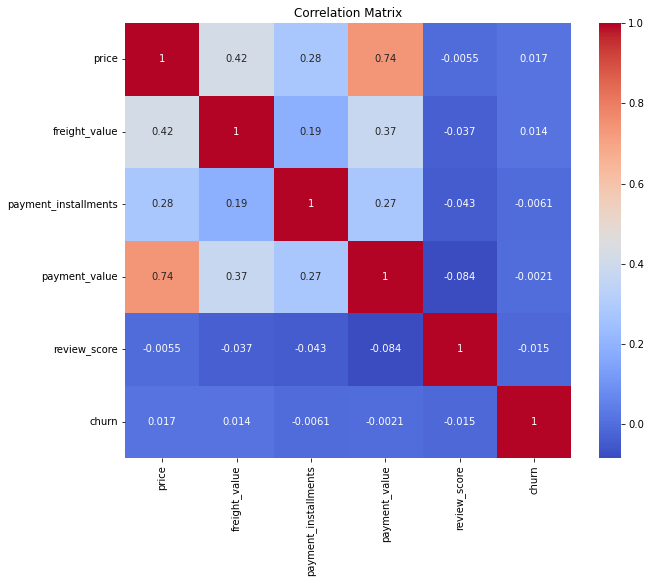

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_with_churn[["price", "freight_value", "payment_installments", "payment_value", "review_score", 'churn']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

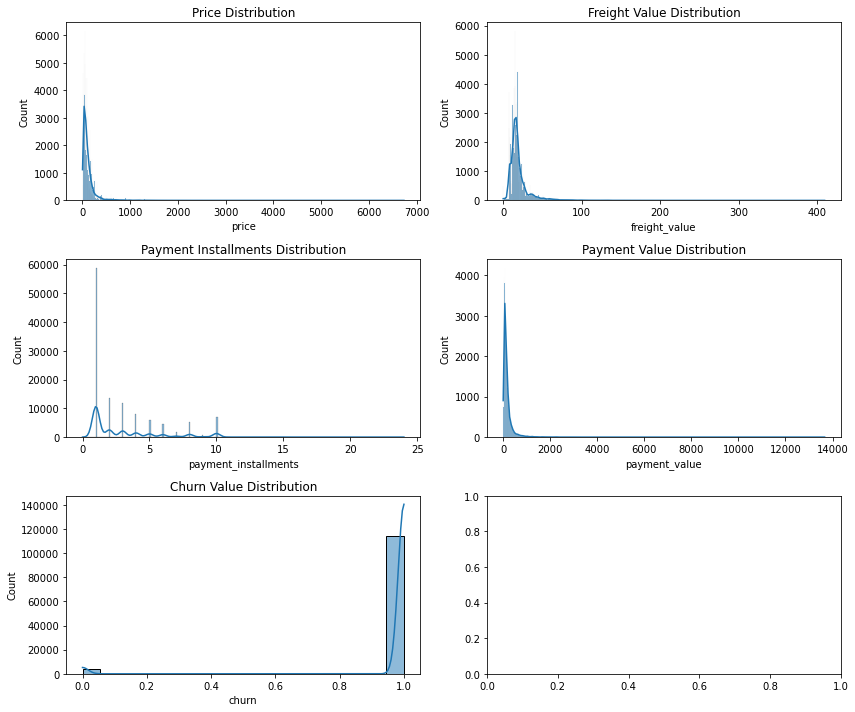

In [60]:
# Plotting distribution plots for numerical columns
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

sns.histplot(df_with_churn["price"], kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Price Distribution")

sns.histplot(df_with_churn["freight_value"], kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Freight Value Distribution")

sns.histplot(df_with_churn["payment_installments"], kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Payment Installments Distribution")

sns.histplot(df_with_churn["payment_value"], kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Payment Value Distribution")

sns.histplot(df_with_churn["churn"], kde=True, ax=axs[2, 0])
axs[2, 0].set_title("Churn Value Distribution")

plt.tight_layout()
plt.show()

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}